In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth
import timeit
from scipy import optimize
import tables
import h5py

#!jt -t onedork -cellw 90%

/home/brandon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
uscal=100
vscal=10
extraterms=True

In [3]:
rnputil=np.load('rnputil.npy')
urange=np.load('urange.npy')[::uscal]
vrange=np.load('vrange.npy')[::vscal]

In [4]:
with h5py.File('rnp.h5','r') as f:
    r_group_key = list(f.keys())[0]
    rnpi=f[r_group_key]
    rnp = np.asarray(rnpi[::uscal,::vscal],dtype=np.float_)    
with h5py.File('signp.h5','r') as f:
    sig_group_key = list(f.keys())[0]
    signpi=f[sig_group_key]
    signp = np.asarray(signpi[::uscal,::vscal],dtype=np.float_)
with h5py.File('phinp.h5','r') as f:
    phi_group_key = list(f.keys())[0]
    phinpi=f[phi_group_key]
    phinp = np.asarray(phinpi[::uscal,::vscal],dtype=np.float_)
with h5py.File('massnp.h5','r') as f:
    mass_group_key = list(f.keys())[0]
    massnpi=f[mass_group_key]
    massnp = np.asarray(massnpi[::uscal,::vscal])
    
    
if extraterms==True:
    with h5py.File('drnpu.h5','r') as f:
        dru_group_key = list(f.keys())[0]
        drnpui=f[dru_group_key]
        drnpu = np.asarray(drnpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('drnpv.h5','r') as f:
        drv_group_key = list(f.keys())[0]
        drnpvi=f[drv_group_key]
        drnpv = np.asarray(drnpvi[::uscal,::vscal],dtype=np.float_)
        
    with h5py.File('dsignpu.h5','r') as f:
        dsigu_group_key = list(f.keys())[0]
        dsignpui=f[dsigu_group_key]
        dsignpu = np.asarray(dsignpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('dsignpv.h5','r') as f:
        dsigv_group_key = list(f.keys())[0]
        dsignpvi=f[dsigv_group_key]
        dsignpv = np.asarray(dsignpvi[::uscal,::vscal],dtype=np.float_)
        
    with h5py.File('dphinpu.h5','r') as f:
        dphiu_group_key = list(f.keys())[0]
        dphinpui=f[dphiu_group_key]
        dphinpu = np.asarray(dphinpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('dphinpv.h5','r') as f:
        dphiv_group_key = list(f.keys())[0]
        dphinpvi=f[dphiv_group_key]
        dphinpv = np.asarray(dphinpvi[::uscal,::vscal],dtype=np.float_)
    
    

print(str(rnp.nbytes)+" bytes")

print(rnp)

switchax=rnputil[9]
print(switchax)
if switchax==True:
    rnp=np.swapaxes(rnp,0,1)
    signp=np.swapaxes(signp,0,1)
    #phinp=np.swapaxes(phinp,0,1)
    #massnp=np.swapaxes(massnp,0,1)
    print("Switched Axes")

#print(massnp[1])
print(rnp[:,4])

7360000 bytes
[[2.         2.01074412 2.02162267 ... 4.14842007 4.14842007 4.14842007]
 [1.97330833 1.98370797 1.99424361 ... 4.14842006 4.14842006 4.14842006]
 [1.94661667 1.95665677 1.96683388 ... 4.14842006 4.14842006 4.14842006]
 ...
 [0.04928875 0.47587831 0.54899771 ... 0.77272346 0.7727235  0.77272354]
 [0.04923584 0.47587831 0.54899771 ... 0.77272346 0.7727235  0.77272354]
 [0.04918316 0.47587831 0.54899771 ... 0.77272346 0.7727235  0.77272354]]
0.0
[2.04377984 2.01572062 1.9875978  1.95941097 1.93115978 1.90284401
 1.87446352 1.84601833 1.81750858 1.78893464 1.76029703 1.73159656
 1.70283429 1.67401163 1.64513035 1.61648915 1.59088509 1.56860896
 1.54921945 1.53233626 1.51763103 1.50481971 1.49365623 1.48392714
 1.4754471  1.46805505 1.46161091 1.4559928  1.45109461 1.44682393
 1.44310027 1.43985349 1.43702248 1.43455396 1.43240149 1.43052459
 1.42888798 1.42746089 1.42621649 1.42513138 1.42418518 1.42336011
 1.42264065 1.42201329 1.42146624 1.42098921 1.42057325 1.42021053
 1

In [5]:
print(rnputil)

M=massnp[0,-1]

N=int(rnputil[0])
Nu=len(urange)#int(rnputil[1])
Nv=len(vrange)#int(rnputil[2])
ru0=float(rnputil[3])
dr0v=float(rnputil[4])
M0=float(rnputil[5])
Q=float(rnputil[6])
Lambda=float(rnputil[7])
umax=np.nanmax(urange)
vmax=np.nanmax(vrange)

print('N='+str(N))

if M0>0.0:
    du0=M0/N
    dv0=du0
else:
    du0=1/N
    dv0=du0
    
#M=nan.max(massnp)

def fr(r,M,Q,Lambda):
    return 1-2*M/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

sol = optimize.root(fr,[0.687,1.3,50.0],args=(M,Q,Lambda), method='hybr',tol=.0000001)
rminus=sol.x[0]
rplus=sol.x[1]
rcosm=sol.x[2]
print(rminus,rplus,rcosm)


['919210000' '91921' '10000' '2.0' '0.053383333333333324' '1.0' '0.98'
 '0.1' 'True' '0.0' 'edd']
N=919210000
0.7727479281957543 1.4178514651566592 4.148420119024598


In [15]:
uval=600
print(0.0,Nu)

0.0 920


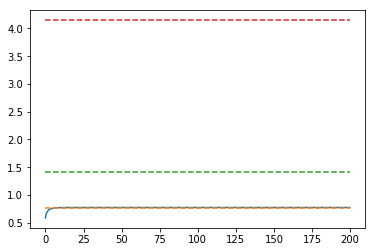

In [16]:
plt.plot(vrange,rnp[uval])
plt.plot([min(vrange),max(vrange)],[rminus,rminus],'--')
plt.plot([min(vrange),max(vrange)],[rplus,rplus],'--')
plt.plot([min(vrange),max(vrange)],[rcosm,rcosm],'--')
#plt.ylim(rcosm-.0000001,rcosm+.0000001)
plt.show()

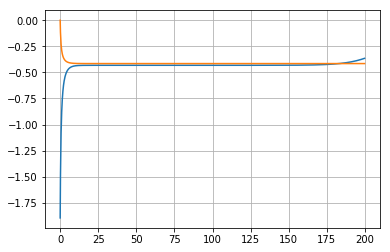

In [17]:
plt.plot(vrange,dsignpv[uval])
plt.plot(vrange,dsignpu[uval])
#plt.yscale('log')
#plt.ylim(-.11,-.09)
plt.grid()
plt.show()

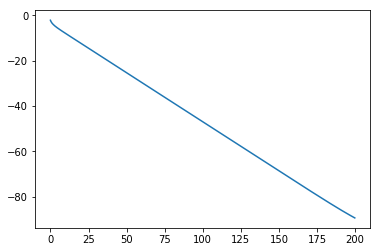

In [18]:
plt.plot(vrange,signp[uval])
plt.show()

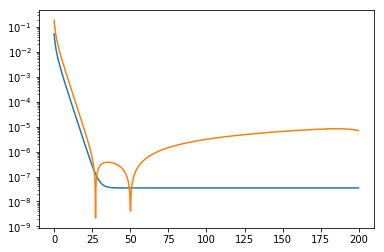

In [19]:
plt.plot(vrange,np.abs(drnpu[uval]))
plt.plot(vrange,np.abs(drnpv[uval]))
plt.yscale('log')
plt.show()

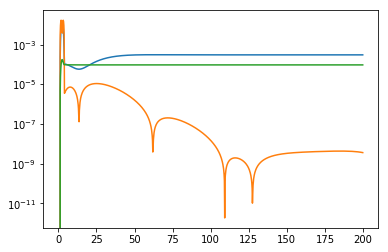

In [20]:
plt.plot(vrange,np.abs(phinp[uval]))
plt.plot(vrange,np.abs(dphinpv[uval]))
plt.plot(vrange,np.abs(dphinpu[uval]))
#plt.plot(vrange,dphinpv[0])
plt.yscale('log')
plt.show()

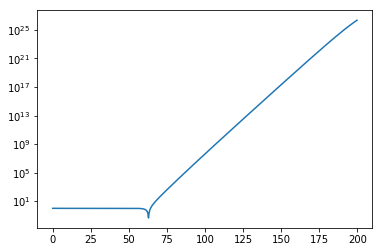

In [21]:
plt.plot(vrange,np.abs(massnp[uval]))
#plt.ylim(massnp[uval,-1]-.00000000001,massnp[uval,-1]+.00000000001)
plt.yscale('log')
plt.show()

In [13]:
print(Nu,Nu,Nu)

920 920 920


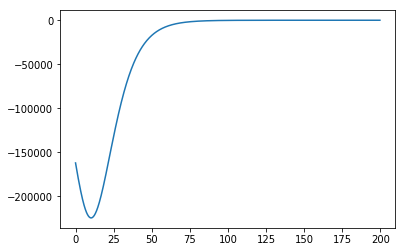

NameError: name 'dsignpv2' is not defined

In [14]:
rnp2=rnp[0,-100]+10**(-15)*np.random.random(Nv)

dsignpv3=2*((massnp[0,-100]*rnp2-Q**2-1/3*Lambda*rnp2**4)/(rnp2**3-2*massnp[0,-100]*rnp2**2+Q**2*rnp2-Lambda/3*rnp2**5))*drnpv[0]
plt.plot(vrange,dsignpv3)
#plt.ylim(-1,1)
plt.show()
print(dsignpv2)

In [ ]:
dsignpv2=2*((massnp[0,0]*rnp[0]-Q**2-1/3*Lambda*rnp[0]**4)/(rnp[0]**3-2*massnp[0,0]*rnp[0]**2+Q**2*rnp[0]-Lambda/3*rnp[0]**5))*drnpv[0]
plt.plot(vrange,dsignpv2)
plt.show()
print(dsignpv2)

In [ ]:
massnp2=massnp[0,-1]+10**(-19)*np.random.random(Nv)

dsignpv2=2*((massnp2*rnp[0,-1]-Q**2-1/3*Lambda*rnp[0,-1]**4)/(rnp[0,-1]**3-2*massnp2*rnp[0,-1]**2+Q**2*rnp[0,-1]-Lambda/3*rnp[0,-1]**5))*drnpv[0]
plt.plot(vrange,dsignpv2)
#plt.ylim(-.12,-.09)
plt.show()
print(dsignpv2)

In [ ]:
print(1.0,.5*(1-2*massnp[0,0]/rnp[0,0]+Q**2.0/rnp[0,0]**2.0-Lambda*rnp[0,0]**2.0/3))